# Introduction to Deep Learning - Week 5 - Miniproject

Peer-graded Assignment: BBC News Classification Kaggle Mini-Project

## 0. Introduction


This notebook is for the assignment of the course Introduction to Deep Learning : Week 5: GANs. The assignment is to apply the GAN method. The miniproject is hosted on Kaggle ("https://www.kaggle.com/competitions/gan-getting-started"). The method is used for generating 7,000 to 10,000 Monet-style images.

The notebook contains the following parts:

1. Exploratory data analysis

2. Applying GAN method

3. Conclusion

## 1. Data and EDA

## 1.1 Libraries and data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# System and Utility Libraries
import os  # For file management
import shutil  # File operations like copying and moving
from glob import glob  # To find file paths matching patterns

# Image Handling Libraries
from PIL import Image  # To open, manipulate, and save images
import numpy as np  # For numerical operations on arrays

# Data Visualization Libraries
import matplotlib.pyplot as plt  # For plotting graphs and images
from sklearn.manifold import TSNE  # For dimensionality reduction (t-SNE)

# TensorFlow Libraries for Deep Learning
import tensorflow as tf  # For building and training neural networks
from tensorflow.keras.models import Sequential, Model  # For defining neural network models
from tensorflow.keras.layers import (Conv2D, Input, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, 
                                     ReLU, Concatenate, ZeroPadding2D)  # Various layers for building neural networks

# Kaggle Dataset Access
from kaggle_datasets import KaggleDatasets  # To access datasets from Kaggle's environment

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

2025-04-29 01:34:28.817849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745890469.031422      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745890469.090757      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Let us check the computational resources

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU!")
except:
    strategy = tf.distribute.get_strategy()  # Default to GPU/CPU
    print("Running on CPU/GPU")
    
# Automatically adjust performance-related parameters during data loading
AUTOTUNE = tf.data.experimental.AUTOTUNE

Running on CPU/GPU


Let us set some parameters beforehand.

In [4]:
class Config():
    seed = 42
    monet_path = '/monet_tfrec/*.tfrec'
    photo_path = '/photo_tfrec/*.tfrec'
    image_size = [256, 256]
    monet_filenames = []
    photo_filenames = []
    identity_weight = 2.0
    batch_size = 1
    epochs = 40

Then, random seed is set for reproducibility

In [5]:
tf.random.set_seed(Config.seed)
np.random.seed(Config.seed)

The next step is loading the data

In [6]:
# get file paths
gcs_path = KaggleDatasets().get_gcs_path()
Config.monet_filenames = tf.io.gfile.glob(str(gcs_path + Config.monet_path))
print('Monet TFRecord Files:', len(Config.monet_filenames))

Config.photo_filenames = tf.io.gfile.glob(str(gcs_path + Config.photo_path))
print('Photo TFRecord Files:', len(Config.photo_filenames))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [7]:
# Define load function
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [8]:
# Decod tfrecords
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*Config.image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [9]:
# Get the two data sets
monet_ds = load_dataset(Config.monet_filenames, labeled=True).batch(1)
photo_ds = load_dataset(Config.photo_filenames, labeled=True).batch(1)

I0000 00:00:1745890481.752773      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## 1.2 Exploration

Let us first the numbers and sizes of the images.

In [10]:
# Count Monet images
monet_count = 0
for _ in monet_ds:
    monet_count += 1

print(f"Total Monet images: {monet_count}")

# Count Photo images
photo_count = 0
for _ in photo_ds:
    photo_count += 1

print(f"Total Photo images: {photo_count}")

Total Monet images: 300
Total Photo images: 7038


In [11]:
# Check one Monet image
print("Monet image size:")
for img in monet_ds.take(1):
    img = tf.squeeze(img, axis=0)
    print(img.shape)

# Check one Photo image
print("Photo image size:")
for img in photo_ds.take(1):
    img = tf.squeeze(img, axis=0)
    print(img.shape)

Monet image size:
(256, 256, 3)
Photo image size:
(256, 256, 3)


Preview one batch for the Monet and Photo datasets 

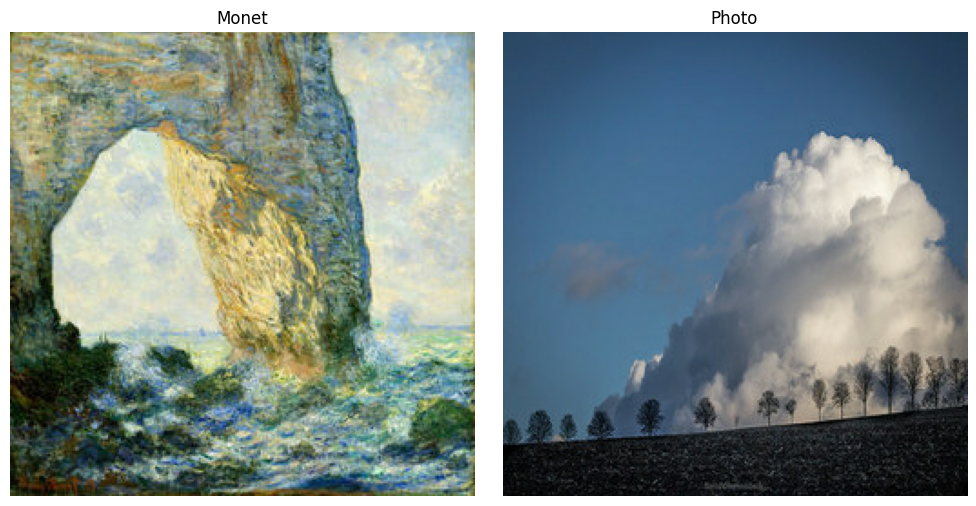

In [31]:
# Take one example out
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

# Plot 1 image from each set
plt.figure(figsize=(10, 5))

# Monet image
ax = plt.subplot(1, 2, 1)
plt.imshow((example_monet[0].numpy() * 0.5 + 0.5))  # Unnormalize if in [-1, 1]
plt.title("Monet")
plt.axis("off")

# Photo image
ax = plt.subplot(1, 2, 2)
plt.imshow((example_photo[0].numpy() * 0.5 + 0.5))  # Unnormalize if in [-1, 1]
plt.title("Photo")
plt.axis("off")

plt.tight_layout()
plt.show()

It can be seen the Monet's painting is more stylish, while the photo is more realistic. Next, let us load some samples and check their difference in color.

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# import tensorflow as tf

#  Collect 50 Monet and 50 Photo images
monet_images = []
photo_images = []

# Load Monet images
for i, img in enumerate(monet_ds):
    img = tf.squeeze(img, axis=0).numpy()  # remove batch dimension
    monet_images.append(img)
    if i == 49:  # stop after 50 images
        break

# Load Photo images
for i, img in enumerate(photo_ds):
    img = tf.squeeze(img, axis=0).numpy()
    photo_images.append(img)
    if i == 49:
        break

# Convert to NumPy arrays
monet_images = np.array(monet_images)
photo_images = np.array(photo_images)

print(f"Loaded {monet_images.shape[0]} Monet images and {photo_images.shape[0]} Photo images.")

Loaded 50 Monet images and 50 Photo images.


Check the distributions of RGB channels.

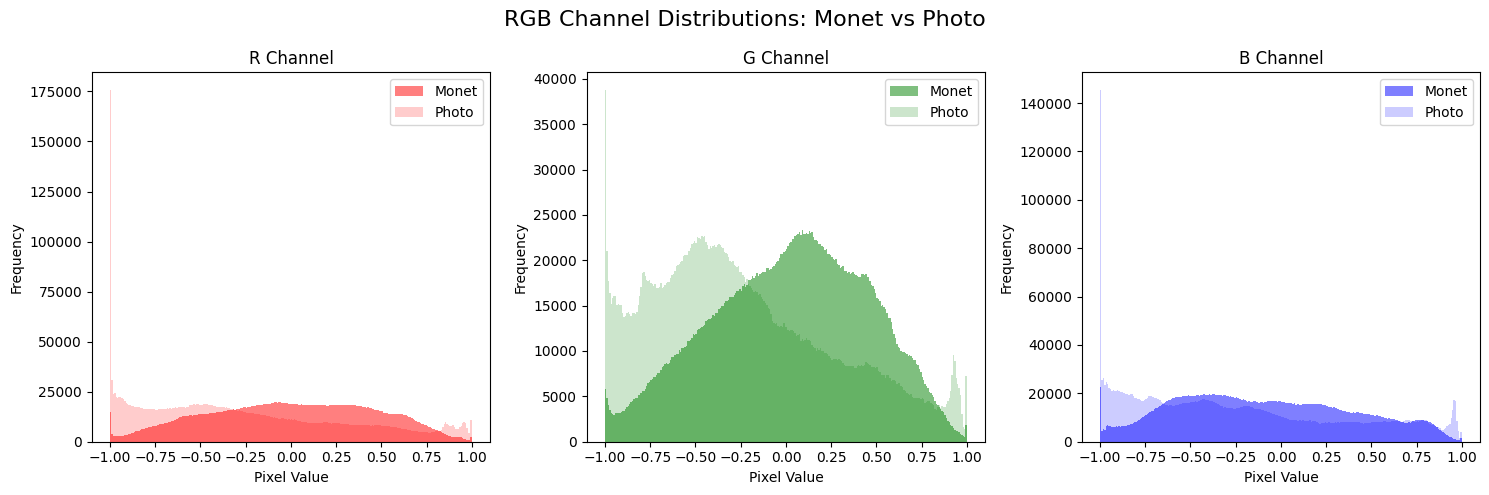

In [14]:
# Plot RGB Channel Distributions
def plot_rgb_histograms(monet_images, photo_images):
    colors = ('r', 'g', 'b')
    
    # Flatten images to 1D arrays
    monet_pixels = monet_images.reshape(-1, 3)
    photo_pixels = photo_images.reshape(-1, 3)
    
    plt.figure(figsize=(15, 5))
    
    for i, color in enumerate(colors):
        plt.subplot(1, 3, i+1)
        plt.hist(monet_pixels[:, i], bins=256, color=color, alpha=0.5, label='Monet')
        plt.hist(photo_pixels[:, i], bins=256, color=color, alpha=0.2, label='Photo')
        plt.title(f'{color.upper()} Channel')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.legend()
    
    plt.suptitle('RGB Channel Distributions: Monet vs Photo', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_rgb_histograms(monet_images, photo_images)


In the RGB channels, lower pixel values indicate dark shades, while higher pixel values indicates greater brightness. It can be seen that the real pictures have relatively darker. However, in the eyes' of the artist, the color is spread more evenly, and the world is brighter and more vivid. Let us do a t-SNE visualization.

OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

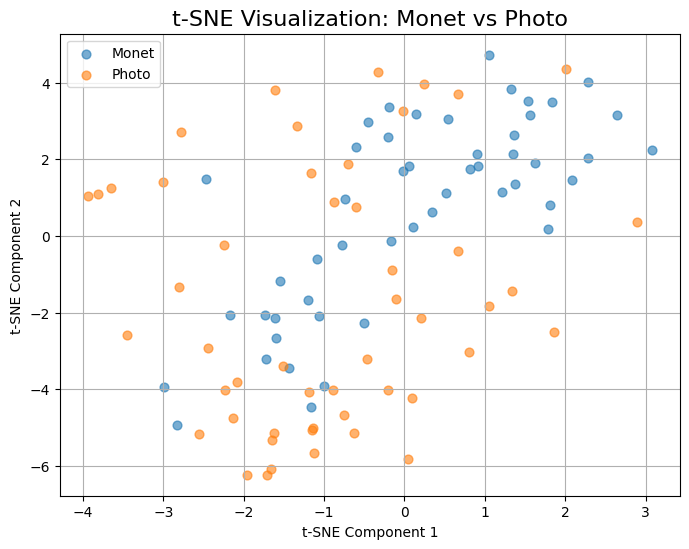

In [15]:
# t-SNE Visualization
def run_tsne(monet_images, photo_images):
    # Flatten images for t-SNE
    monet_flat = monet_images.reshape(monet_images.shape[0], -1)
    photo_flat = photo_images.reshape(photo_images.shape[0], -1)
    
    # Combine data
    X = np.vstack((monet_flat, photo_flat))
    y = np.array([0]*monet_flat.shape[0] + [1]*photo_flat.shape[0])  # 0 = Monet, 1 = Photo

    # Normalize X (important for t-SNE stability)
    X = X / 255.0

    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=500)
    X_embedded = tsne.fit_transform(X)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X_embedded[y==0, 0], X_embedded[y==0, 1], label='Monet', alpha=0.6, s=40)
    plt.scatter(X_embedded[y==1, 0], X_embedded[y==1, 1], label='Photo', alpha=0.6, s=40)
    plt.legend()
    plt.title('t-SNE Visualization: Monet vs Photo', fontsize=16)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

run_tsne(monet_images, photo_images)

By the t-SNE, the images are transformed to 2D representations. It suggests the points for  the real photos surrounds the points for the Monet's works, suggests two clusters.

## 2. CycleGan Model

CycleGAN is a type of Generative Adversarial Network (GAN) designed for unpaired image-to-image translation. Unlike traditional supervised models that require paired images (e.g., a specific photo and its corresponding painting), CycleGAN can learn mappings between two domains (e.g., photos and Monet paintings) without requiring exact pairings. The main characteristics of CycleGAN include:

- It enables style transfer and domain translation without needing perfectly aligned datasets.
- It captures both **content** and **style** while maintaining **structural consistency**.
- It is widely used in applications like photo enhancement, artistic style transfer, object transfiguration, and more.

In this project, CycleGAN is used to learn the artistic style of Monet paintings and apply it to real-world photos, generating realistic Monet-style images without paired training data.


## 2.1 Model building

First, create two helper functions to reduce/increase image size.

In [16]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential([
        Conv2D(filters, size, strides=2, padding='same',
               kernel_initializer=initializer, use_bias=False),
    ])
    if apply_batchnorm:
        result.add(BatchNormalization())
        
    result.add(LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential([
        Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False),
        BatchNormalization()
    ])
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

The next is the Generator. It uses the two helper functions. Features are extracted, and used for reconstruct image.

In [17]:
def Generator():
    inputs = Input(shape=[*Config.image_size, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
    ]
    up_stack = [
        upsample(128, 4),  # (bs, 64, 64, 128)
        upsample(64, 4),   # (bs, 128, 128, 64)
    ]
    last = Conv2DTranspose(3, 4, strides=2, padding='same',
                            kernel_initializer=tf.random_normal_initializer(0., 0.02),
                            activation='tanh')  # (bs, 256, 256, 3)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)
    return Model(inputs=inputs, outputs=x)

Then, the Discriminator for disguishing acutal iamges from the generated by the Generator.

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = Input(shape=[*Config.image_size, 3], name='input_image')
    x = downsample(64, 4, False)(inp)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    x = ZeroPadding2D()(x)
    x = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = ZeroPadding2D()(x)
    x = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)
    return Model(inputs=inp, outputs=x)


For the CycleGAN architecture, we set two generators and two discriminators

In [19]:
generator_g = Generator()  # From Monet-style images to Photo-style images
generator_f = Generator()  # From Photo-style images to Monet-style images

discriminator_x = Discriminator()  # Distinguish real/fake Monet images
discriminator_y = Discriminator()  # Discriminator real/fake Photoimages

Check the architecture of the CycleGAN model.

In [20]:
generator_g.summary()
discriminator_x.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128, 128, 64)   │          3,072 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 64, 64, 128)    │        131,584 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 32, 32, 256)    │        525,312 │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 64, 64, 128)    │        524,800 │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 256)    │              0 │ sequential_3[0][0],    │
│                           │                        │                │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 128, 128, 64)   │        262,400 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 128, 128)  │              0 │ sequential_4[0][0],    │
│ (Concatenate)             │                        │                │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 256, 256, 3)    │          6,147 │ concatenate_1[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,453,315 (5.54 MB)

 Trainable params: 1,452,163 (5.54 MB)

 Non-trainable params: 1,152 (4.50 KB)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_10 (Sequential)           │ (None, 128, 128, 64)        │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_11 (Sequential)           │ (None, 64, 64, 128)         │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_12 (Sequential)           │ (None, 32, 32, 256)         │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 31, 31, 512)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 31, 31, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 31, 31, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 33, 33, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 30, 30, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,767,361 (10.56 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

Let's create loss functions for CycleGAN. The model uses a combination of adversarial, cycle consistency, and identity losses to guide both the generators and discriminators.
* discriminator_loss - train discriminator to separate real/fake
* generator_loss - train generator to fool discriminator
* cycle_loss - ensure round-trip image consistency
* identity_loss - preserve input when already in target domain

In [21]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * 10.0

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * 5.0

In a single training step, the Generators and Discriminators are evaluated by how well they can fake or distinguish fake images, respectively. The losses and learning processes are defined accordingly, in the following function.

In [22]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y) * Config.identity_weight
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Apply gradients
    generator_g_grad = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_grad = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_grad = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_grad = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_grad, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_grad, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_grad, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_grad, discriminator_y.trainable_variables))


### 2.2 Model training

First, define a helper function for logging losses.

In [23]:
def recalc_losses():
    sample_photo = next(iter(photo_ds))
    sample_monet = next(iter(monet_ds))

    fake_y = generator_g(sample_photo, training=False)
    cycled_x = generator_f(fake_y, training=False)
    fake_x = generator_f(sample_monet, training=False)
    cycled_y = generator_g(fake_x, training=False)
    same_x = generator_f(sample_photo, training=False)
    same_y = generator_g(sample_monet, training=False)

    disc_real_x = discriminator_x(sample_photo, training=False)
    disc_fake_x = discriminator_x(fake_x, training=False)
    disc_real_y = discriminator_y(sample_monet, training=False)
    disc_fake_y = discriminator_y(fake_y, training=False)

    # Calculate losses for visualization
    g_loss = generator_loss(disc_fake_y)
    f_loss = generator_loss(disc_fake_x)
    cyc_loss = cycle_loss(sample_photo, cycled_x) + cycle_loss(sample_monet, cycled_y)
    id_loss = identity_loss(sample_monet, same_y) + identity_loss(sample_photo, same_x)
    dx_loss = discriminator_loss(disc_real_x, disc_fake_x)
    dy_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Append losses
    gen_g_losses.append(g_loss.numpy())
    gen_f_losses.append(f_loss.numpy())
    disc_x_losses.append(dx_loss.numpy())
    disc_y_losses.append(dy_loss.numpy())
    cycle_losses.append(cyc_loss.numpy())
    identity_losses.append(id_loss.numpy())

In the meantime, let us preview the generated images every 5 epochs.

In [24]:
def visualize_epoch_result(epoch):
    # Visualize intermediate epochs
    if (epoch + 1) % 5 == 0:
        os.makedirs("cycle_outputs", exist_ok=True)  # visual the output for every 5 epoch
        
        sample_photo = next(iter(photo_ds))
        prediction = generator_g(sample_photo)
    
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow((sample_photo[0] * 0.5 + 0.5).numpy())
        plt.title("Input")
        plt.axis('off')
    
        plt.subplot(1, 2, 2)
        plt.imshow((prediction[0] * 0.5 + 0.5).numpy())
        plt.title(f"Epoch {epoch+1}")
        plt.axis('off')
    
        plt.tight_layout()
        plt.savefig(f"cycle_outputs/epoch_{epoch+1}.png")
        plt.show()

Set the initial and the updated rule for the learning rate. Using $\beta_0=0.5$ for stabilizing the GAN model.

In [25]:
initial_lr = 2e-4
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[20],  
    values=[initial_lr, initial_lr * 0.5]  # decay to half after 20 epochs
)

# apply clipnorm=1.0 to make backpropagation more stable
generator_g_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5, clipnorm=1.0)
generator_f_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)

Initialize the log lists, and preview the generated images.

I0000 00:00:1745890533.182197      90 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/40 done.
Epoch 2/40 done.
Epoch 3/40 done.
Epoch 4/40 done.


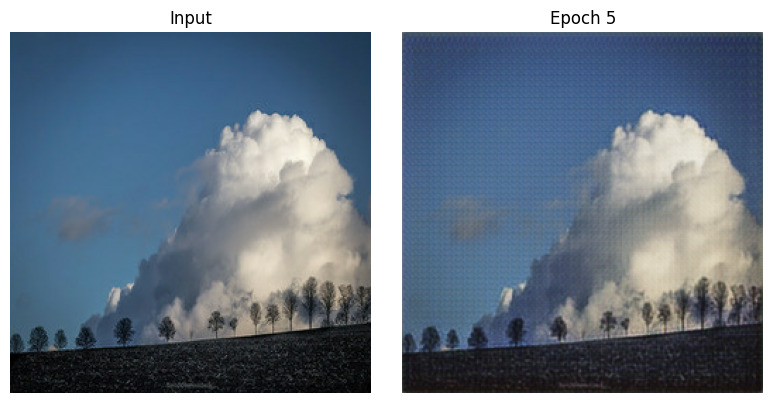

Epoch 5/40 done.
Epoch 6/40 done.
Epoch 7/40 done.
Epoch 8/40 done.
Epoch 9/40 done.


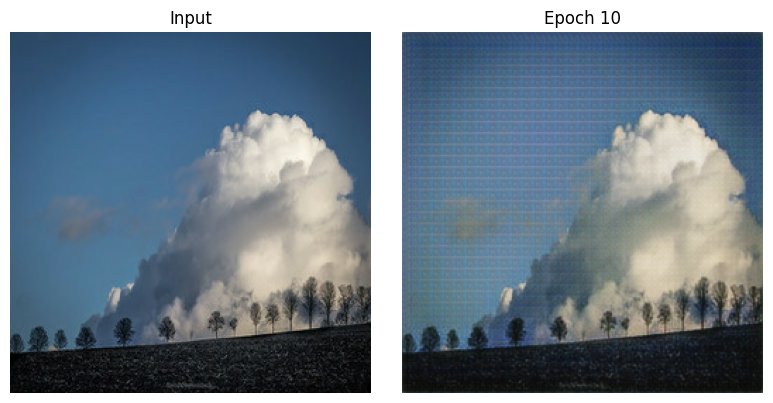

Epoch 10/40 done.
Epoch 11/40 done.
Epoch 12/40 done.
Epoch 13/40 done.
Epoch 14/40 done.


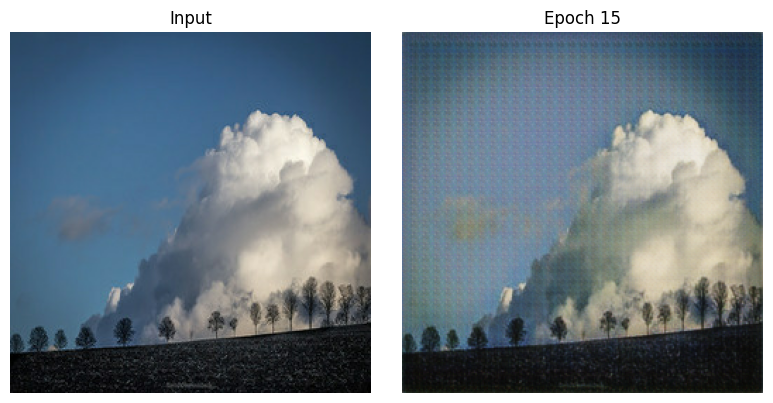

Epoch 15/40 done.
Epoch 16/40 done.
Epoch 17/40 done.
Epoch 18/40 done.
Epoch 19/40 done.


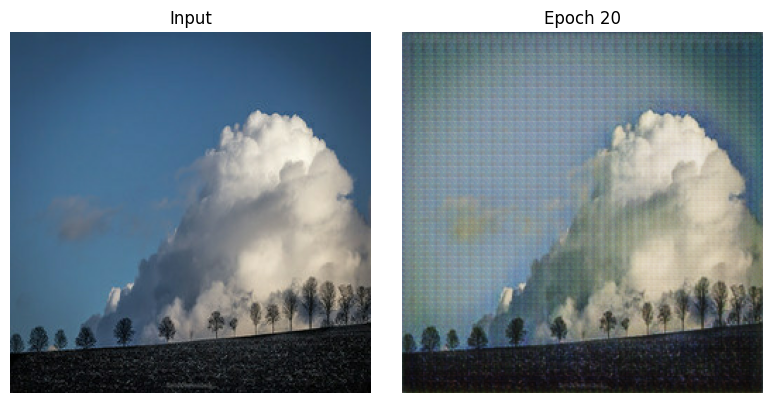

Epoch 20/40 done.
Epoch 21/40 done.
Epoch 22/40 done.
Epoch 23/40 done.
Epoch 24/40 done.


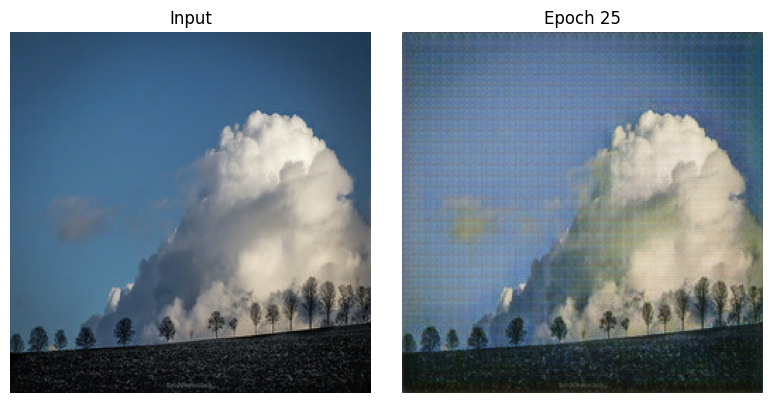

Epoch 25/40 done.
Epoch 26/40 done.
Epoch 27/40 done.
Epoch 28/40 done.
Epoch 29/40 done.


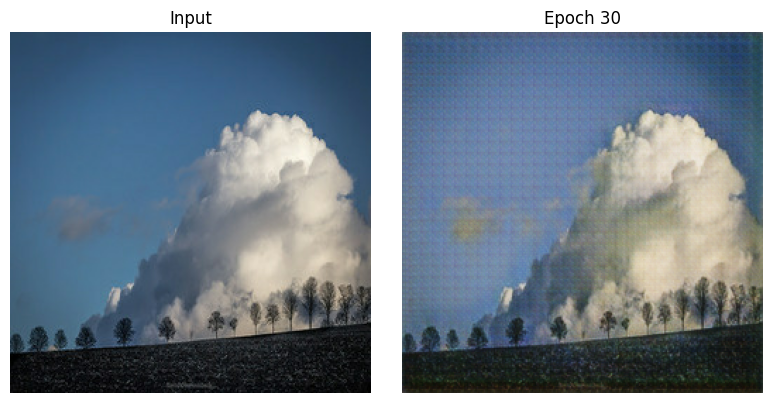

Epoch 30/40 done.
Epoch 31/40 done.
Epoch 32/40 done.
Epoch 33/40 done.
Epoch 34/40 done.


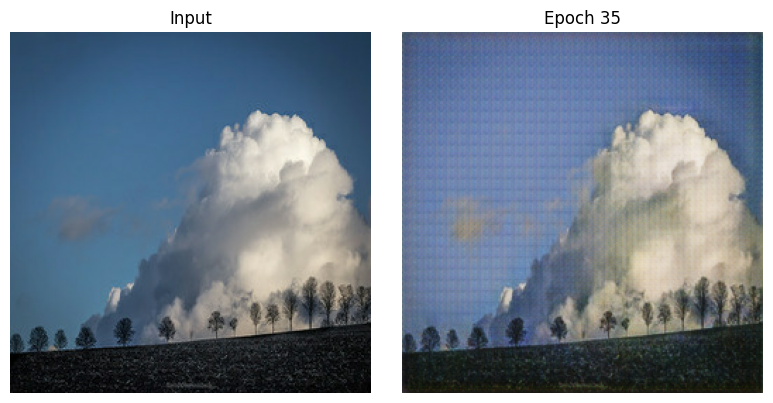

Epoch 35/40 done.
Epoch 36/40 done.
Epoch 37/40 done.
Epoch 38/40 done.
Epoch 39/40 done.


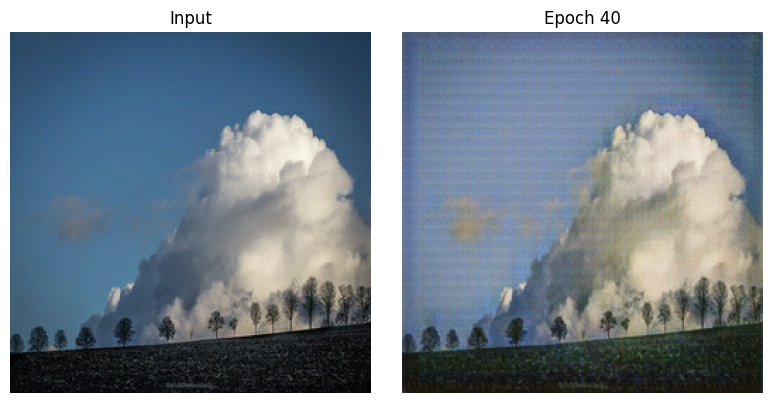

Epoch 40/40 done.


In [26]:
gen_g_losses = []
gen_f_losses = []
disc_x_losses = []
disc_y_losses = []
cycle_losses = []
identity_losses = []

for epoch in range(Config.epochs):
    for image_x, image_y in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(image_x, image_y)
        
    recalc_losses()
    visualize_epoch_result(epoch)
    
    print(f"Epoch {epoch+1}/{Config.epochs} done.")

## 2.3 Evaluation

Let us first check the losses in the training process. It can be seen that the loss  are stabilized in the process. It seems that the suitable epoch setting is 30 in this case, and after 30 epochs, the generated images are nore easily distinguished.

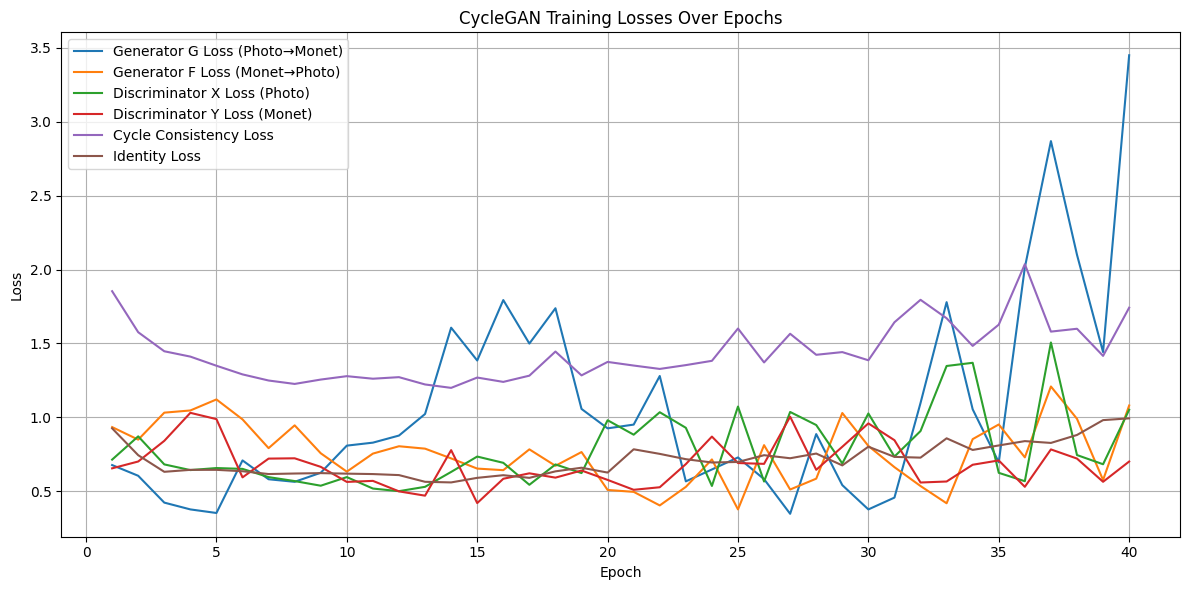

In [27]:
epochs = range(1, len(gen_g_losses) + 1)

plt.figure(figsize=(12, 6))

plt.plot(epochs, gen_g_losses, label='Generator G Loss (Photo→Monet)')
plt.plot(epochs, gen_f_losses, label='Generator F Loss (Monet→Photo)')
plt.plot(epochs, disc_x_losses, label='Discriminator X Loss (Photo)')
plt.plot(epochs, disc_y_losses, label='Discriminator Y Loss (Monet)')
plt.plot(epochs, cycle_losses, label='Cycle Consistency Loss')
plt.plot(epochs, identity_losses, label='Identity Loss')

plt.title("CycleGAN Training Losses Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Finally, check some generated images.

In [28]:
#  Handle and visualize generated images.
def generate_images(model, test_input):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(12, 6))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Translated Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow((display_list[i] * 0.5 + 0.5).numpy())  # rescale to [0, 1]
        plt.axis('off')
    plt.show()

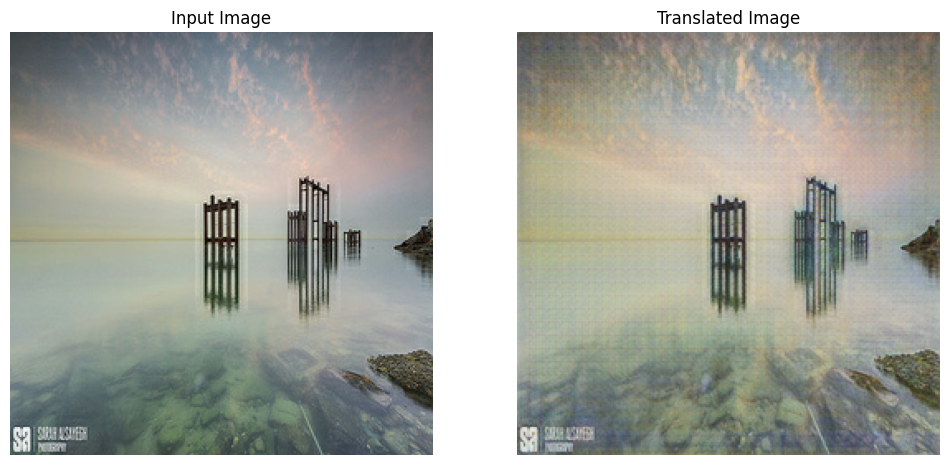

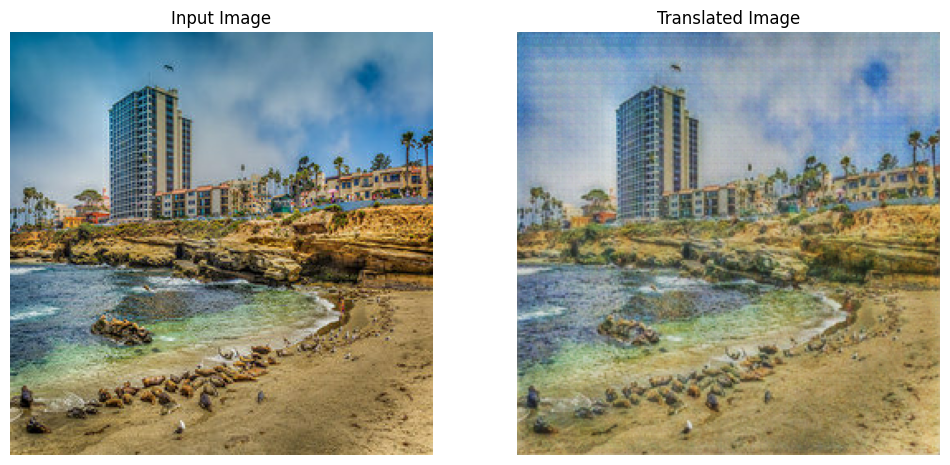

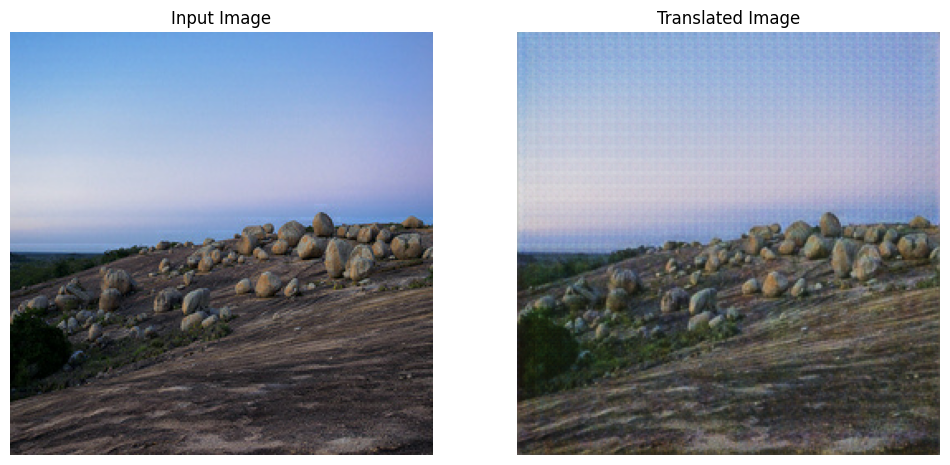

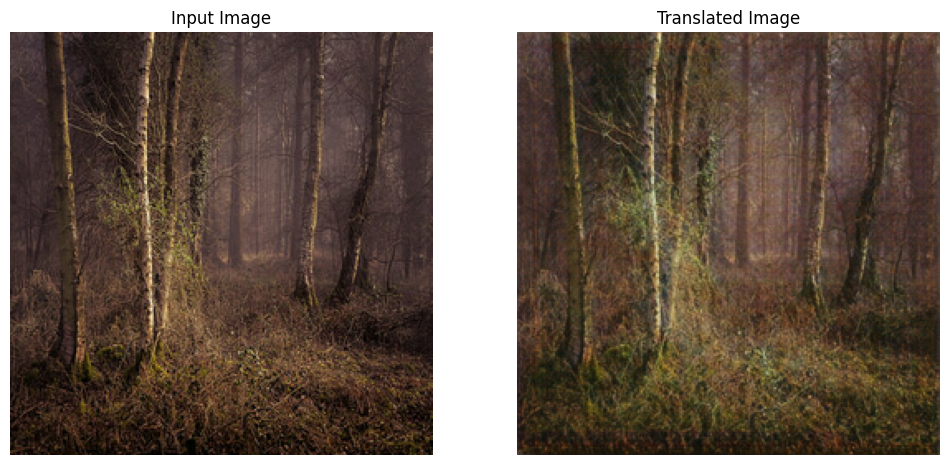

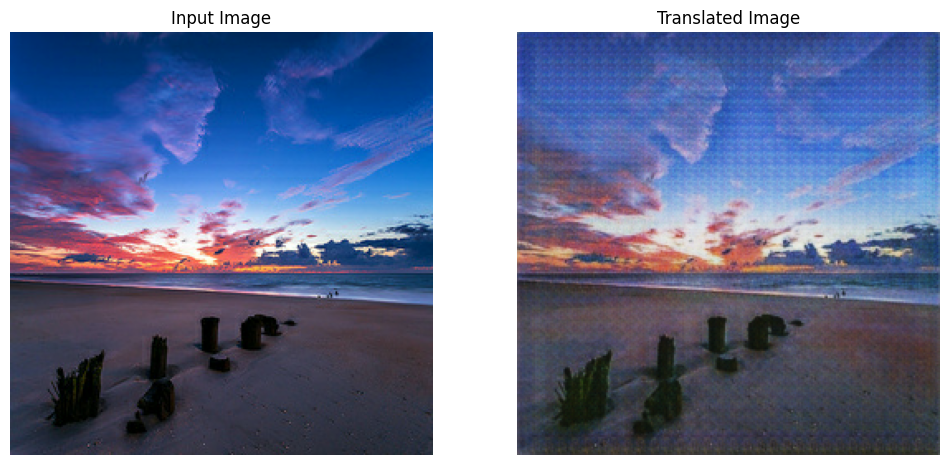

In [29]:
# Check some generated images
import random

# Turn dataset into a list (only works if dataset is small)
all_batches = list(photo_ds)
random_batches = random.sample(all_batches, 5)  # random selection

# Generate images from random batches
for batch in random_batches:
    generate_images(generator_g, batch)


Comparing the real and Monet-style images, the generated are more like paintings.

## 3. Conclusion

In this notebook, the CycleGAN method is applied to generate Monet-style images. The results show the generated images are more like paitings, and have greater brightness.

## 4. Submission

The final step is to store the generated image to files.

In [30]:
# Create a save directory first
os.makedirs("/kaggle/working/images", exist_ok=True)

i = 1  # index for the file name
for img in photo_ds:
    prediction = generator_g(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save(f"/kaggle/working/images/{i}.jpg")  # ← Save inside working/images
    i += 1

# Make the zip file
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")


'/kaggle/working/images.zip'

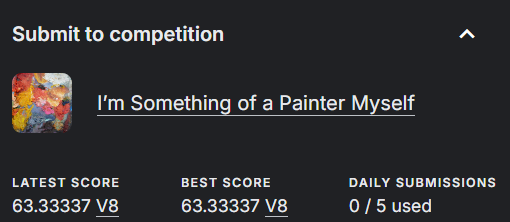